In [21]:
# Importing pakages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import pickle

from sklearn.preprocessing import StandardScaler

# import warnings
# warnings.filterwarnings('ignore')

In [22]:
data = pd.read_csv('diabetes_preprocessed.csv')

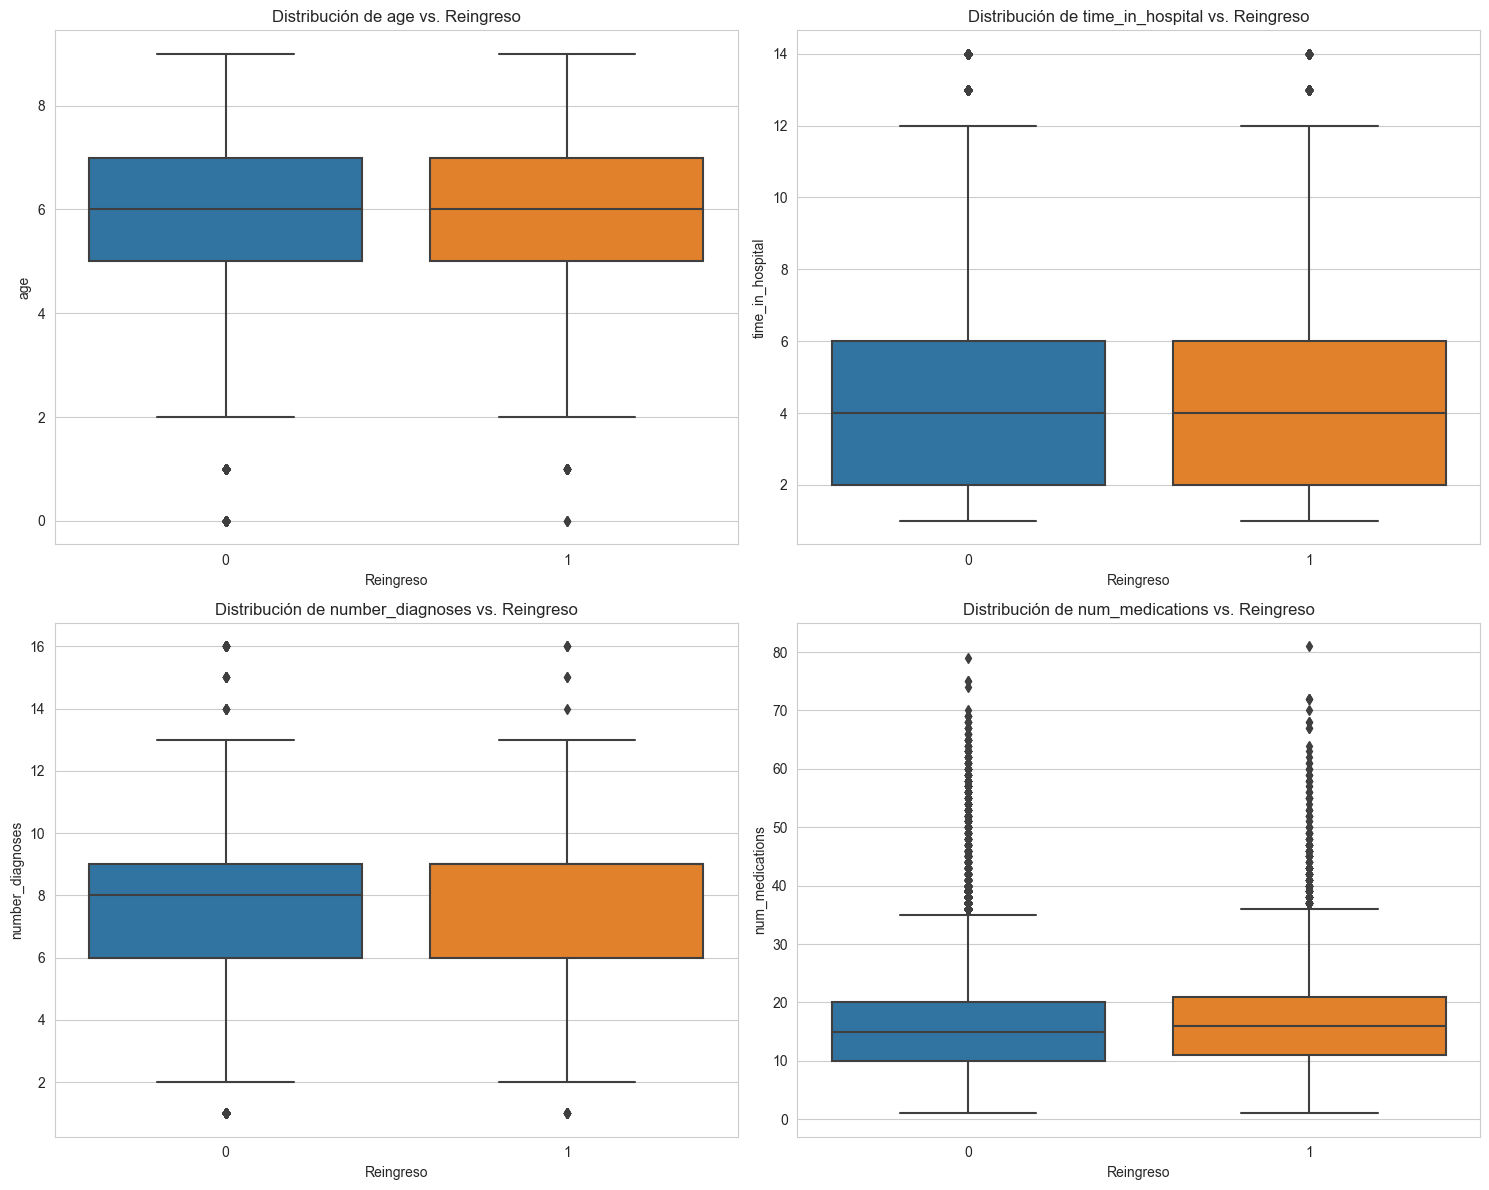

In [23]:
# Configuración de estilos de Seaborn
sns.set_style("whitegrid")

# Definir las columnas de interés para la visualización
cols_of_interest = ['age', 'time_in_hospital', 'number_diagnoses', 'num_medications']

# Crear subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# Bucle para visualizar las distribuciones
for i, col in enumerate(cols_of_interest):
    ax = axes[i//2, i%2]
    sns.boxplot(x='readmitted', y=col, data=data, ax=ax)
    ax.set_title(f"Distribución de {col} vs. Reingreso")
    ax.set_xlabel("Reingreso")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()


- Edad vs. Reingreso: Mayor proporción de jóvenes no readmitidos.
- Tiempo en el hospital vs. Reingreso: Más tiempo en hospital, ligeramente mayor riesgo de reingreso.
- Número de diagnósticos vs. Reingreso: Pacientes readmitidos tienen más diagnósticos.
- Número de medicamentos vs. Reingreso: Pacientes readmitidos toman más medicamentos.

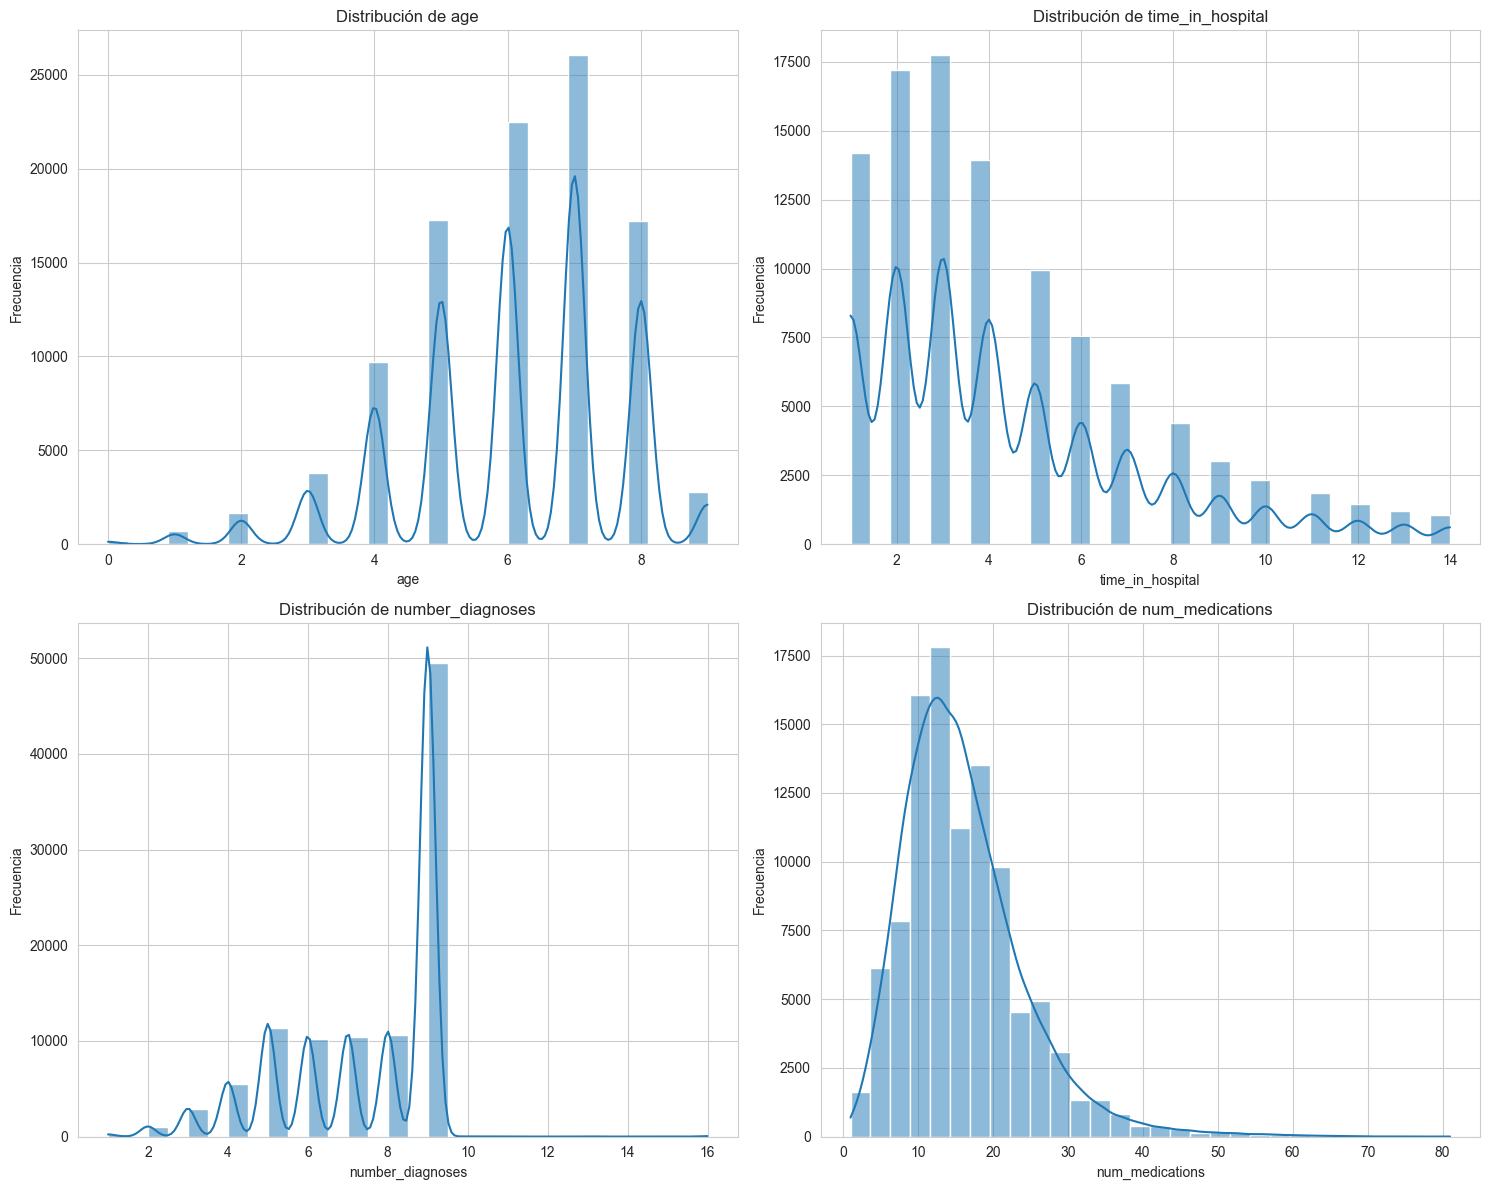

In [24]:
# Crear subplots para los histogramas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# Bucle para visualizar las distribuciones
for i, col in enumerate(cols_of_interest):
    ax = axes[i//2, i%2]
    sns.histplot(data[col], bins=30, kde=True, ax=ax)
    ax.set_title(f"Distribución de {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


- Edad: Variable ya categorizada; considerar estandarización si se convierte en continua.
- Tiempo en el hospital: Sugerida transformación logarítmica por sesgo hacia la derecha.
- Número de diagnósticos: Estandarización podría ser beneficiosa para ciertos modelos.
- Número de medicamentos: Considerar transformación logarítmica debido al sesgo.

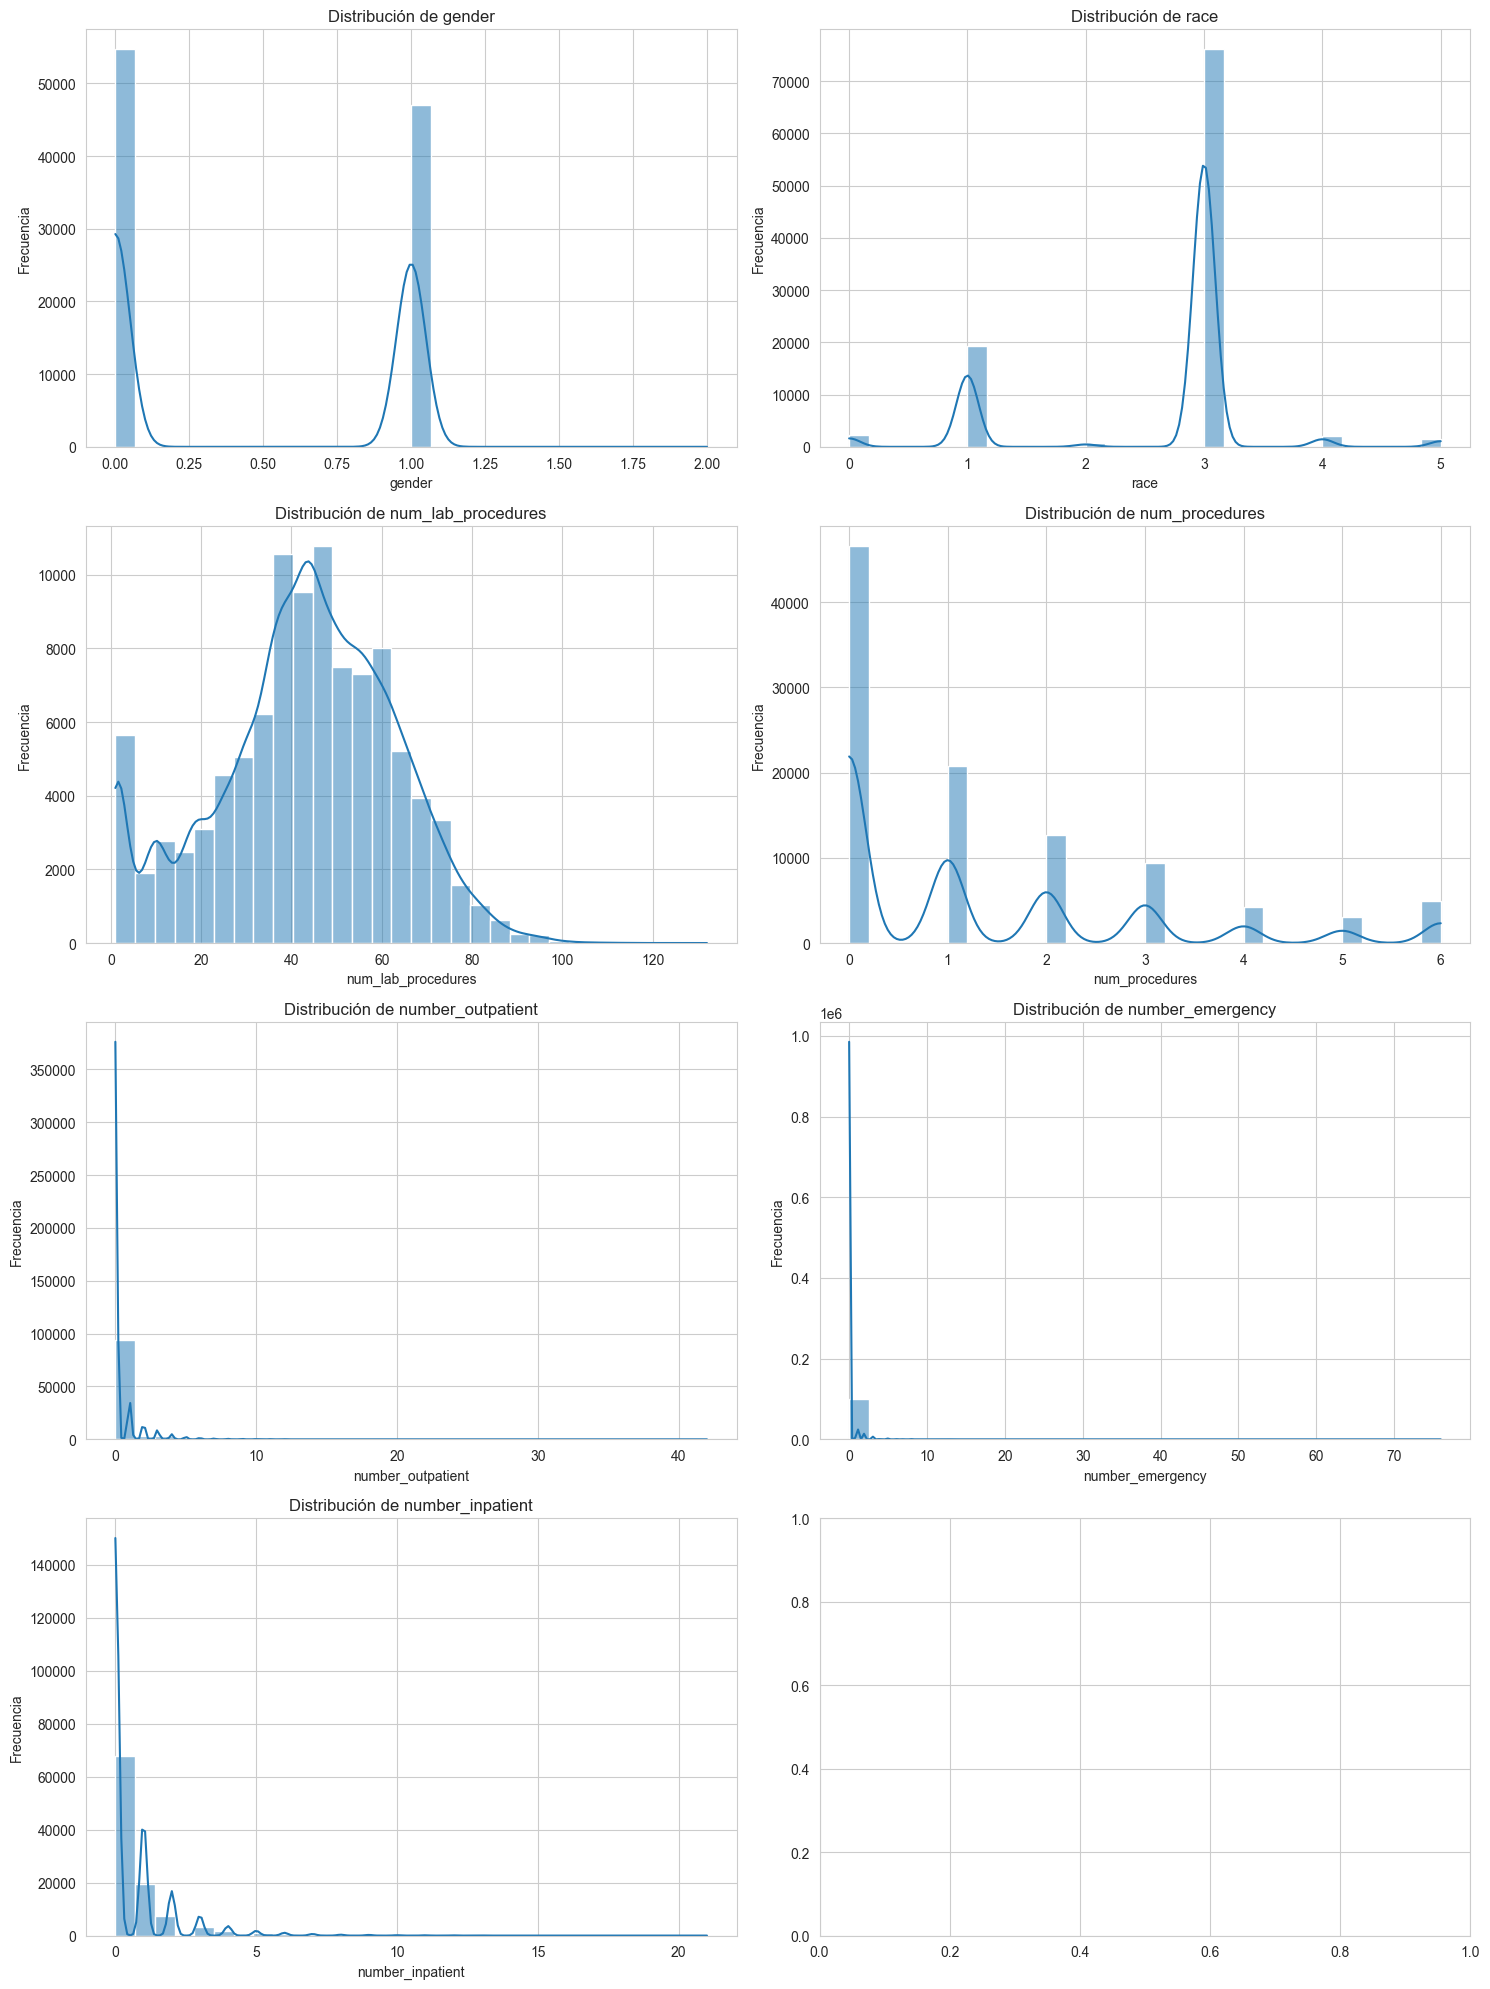

In [25]:
# Definir las columnas adicionales de interés
additional_cols = ['gender', 'race', 'num_lab_procedures', 'num_procedures', 
                   'number_outpatient', 'number_emergency', 'number_inpatient']

# Crear subplots para los histogramas
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

# Bucle para visualizar las distribuciones
for i, col in enumerate(additional_cols):
    ax = axes[i//2, i%2]
    sns.histplot(data[col], bins=30, kde=True, ax=ax)
    ax.set_title(f"Distribución de {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frecuencia")

# Ajuste para evitar superposición
plt.tight_layout()
plt.show()

- Género: Distribución equitativa con leve predominio del género codificado como 0.
- Raza: Mayoría pertenece a la categoría codificada como 3; otras categorías menos representadas.
- Número de procedimientos de laboratorio: Distribución uniforme con pico en 40-60 procedimientos.
- Número de procedimientos: Predominio de pacientes con pocos procedimientos.
- Visitas (ambulatorias, emergencia, ingresos hospitalarios): Sesgo hacia la derecha; la mayoría tiene pocas visitas/ingresos.

In [26]:

to_log_transform = ['num_procedures', 'number_outpatient', 'number_emergency', 'number_inpatient', 'time_in_hospital']

# Aplicar transformación logarítmica (después de agregar 1) nuevamente
for col in to_log_transform:
    data[col] = data[col].apply(lambda x: np.log1p(x))

data.head()


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,number_diagnoses,max_glu_serum,A1Cresult,metformin,glipizide,glyburide,insulin,change,diabetesMed,readmitted
0,2278392,8222157,3,0,0,6,25,1,0.693147,41,...,1,3,3,1,1,1,1,1,0,0
1,149190,55629189,3,0,1,1,1,7,1.386294,59,...,9,3,3,1,1,1,3,0,1,0
2,64410,86047875,1,0,2,1,1,7,1.098612,11,...,6,3,3,1,2,1,1,1,1,0
3,500364,82442376,3,1,3,1,1,7,1.098612,44,...,7,3,3,1,1,1,3,0,1,0
4,16680,42519267,3,1,4,1,1,7,0.693147,51,...,5,3,3,1,2,1,2,0,1,0


In [27]:
# Inicializar el estandarizador
scaler = StandardScaler()

# Variables a estandarizar
to_scale = ['num_lab_procedures', 'number_diagnoses', 'num_medications']

# Aplicar estandarización
data[to_scale] = scaler.fit_transform(data[to_scale])

data.head()


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,number_diagnoses,max_glu_serum,A1Cresult,metformin,glipizide,glyburide,insulin,change,diabetesMed,readmitted
0,2278392,8222157,3,0,0,6,25,1,0.693147,-0.106517,...,-3.321596,3,3,1,1,1,1,1,0,0
1,149190,55629189,3,0,1,1,1,7,1.386294,0.808384,...,0.815784,3,3,1,1,1,3,0,1,0
2,64410,86047875,1,0,2,1,1,7,1.098612,-1.631351,...,-0.735733,3,3,1,2,1,1,1,1,0
3,500364,82442376,3,1,3,1,1,7,1.098612,0.045967,...,-0.218561,3,3,1,1,1,3,0,1,0
4,16680,42519267,3,1,4,1,1,7,0.693147,0.401761,...,-1.252906,3,3,1,2,1,2,0,1,0


In [28]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [29]:
# 1. Combinar medicamentos
data['total_meds'] = data['metformin'] + data['glipizide'] + data['glyburide'] + data['insulin']

# 2. Indicador de gravedad
data['severity_indicator'] = data['number_outpatient'] + data['number_emergency'] + data['number_inpatient']


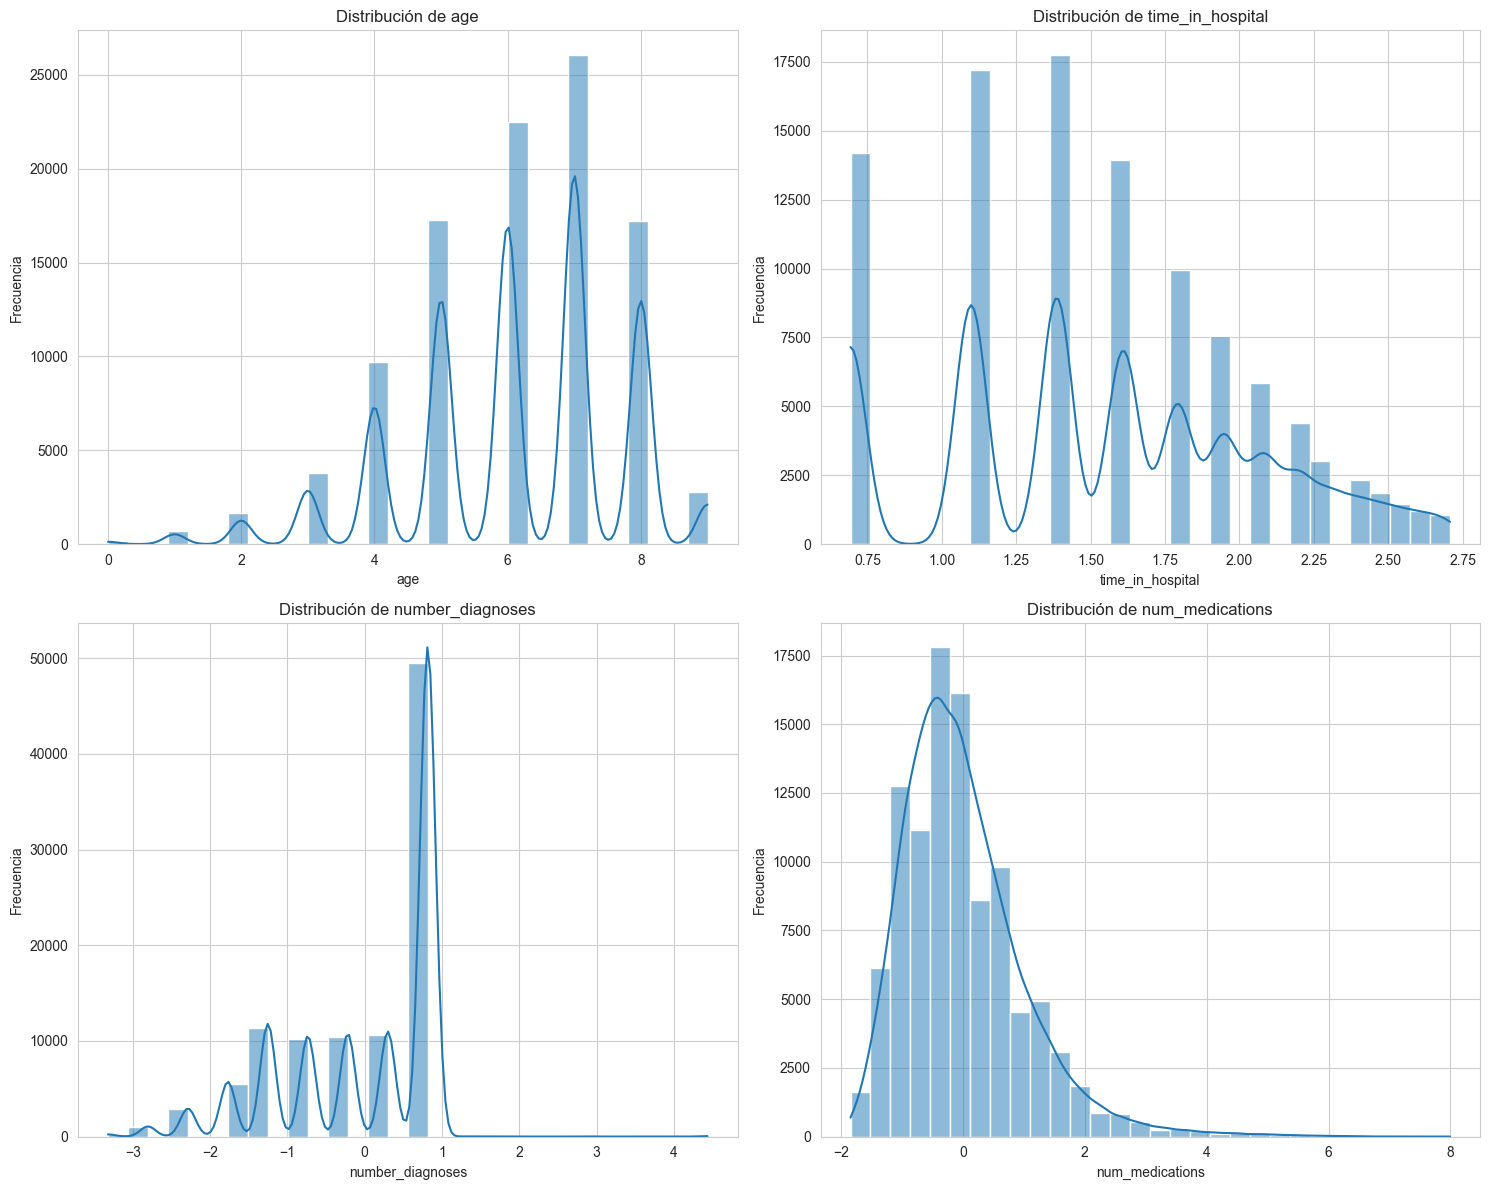

In [30]:
# Crear subplots para los histogramas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# Bucle para visualizar las distribuciones
for i, col in enumerate(cols_of_interest):
    ax = axes[i//2, i%2]
    sns.histplot(data[col], bins=30, kde=True, ax=ax)
    ax.set_title(f"Distribución de {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


In [31]:
data.to_csv('data_transformed.csv', index=False)